In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
import pandas as pd  # library for data analysis for text files (everything but netcdf files)
import xarray  #package that open and manipulates netcdf files
import matplotlib.dates as mdates
import numpy.linalg as LA
from matplotlib.gridspec import GridSpec
import timeit
#from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
print('finished...')

finished...


### Read in data

In [2]:
                           
file = xarray.open_dataset('b.e11.BRCP85C5CNBDRD.f09_g16.001.cam.h0.TS.208101-210012.nc')
tbounds = file['time_bnds'].isel(nbnd=0) ##  pick out beginning of bound, first index of bound.
file['time'] = tbounds.values  ## replace time with beginning of bound
print(file['time'][0]) ## check that the first time is now Jan 1
#-------
# Convert pesky CFtime to datetime
datetimeindex = file.indexes['time'].to_datetimeindex()
file['time'] = datetimeindex
#-------
lon  = file["lon"]
lat  = file["lat"]
time = file["time"]
global_data = file["TS"] # surface temperature in K

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(2081, 1, 1, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    time     object 2081-01-01 00:00:00


/var/folders/w8/4rtmbwnj4f1cgjcwdrx292mdj0l3_j/T/ipykernel_87154/3553490813.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = file.indexes['time'].to_datetimeindex()


## Problem 1.1

### Post process the data

In [3]:
#--------------------------------------------
# subset the data
minlat = 25
maxlat = 55
minlon = 220
maxlon = 300
# subset data to the northern hemisphere lons/lats 
# subset data to January 2081 through December 2100
TSF = file["TS"].sel(lat=slice(minlat,maxlat))\
                   .sel(lon=slice(minlon,maxlon))\
                   .sel(time=slice('2081-01-01','2100-12-31')) 
nh_lon = file["lon"].sel(lon=slice(minlon,maxlon)) # 65
nh_lat = file["lat"].sel(lat=slice(minlat,maxlat)) # 31
nyrs = 20
print('TSF shape:', np.shape(TSF)) # shape [time, lat, lon]
print('lons shape:', np.shape(nh_lon))
print('lats shape:', np.shape(nh_lat))
#--------------------------------------------
# weight the data by the square root of the cosine, Following Hannachi et al. 2007 pg 1123
TSFwgt = TSF*np.sqrt(np.cos(lat*np.pi/180)) ##np.sqrt(np.cos(nh_lat*np.pi/180))

#--------------------------------------------
# Get both anomalies 
TSFanom = TSF-TSF.mean('time')          # normal anomaly
TSFwgtanom = TSFwgt-TSFwgt.mean('time') # weighted lat anomaly

#--------------------------------------------
# Remove the seasonal cycle (keep by default)
climo = TSFwgtanom.groupby('time.month').mean('time') # get the moving monthly average
TSFwgtanom = TSFwgtanom.groupby('time.month')-climo   # subtract by moving monthly average to remove seasonality

#--------------------------------------------
# Standardize the data
TSFwgtanomSTD = TSFwgtanom/(TSFwgtanom.std('time'));
print('mean:', float(np.mean(TSFwgtanomSTD)))
print('std:', float(np.std(TSFwgtanomSTD)))

#--------------------------------------------
# Remove NaNs as needed
flag  = np.where(TSF.values==np.nan)
count = np.sum(flag)
if count != 0:
    print('NaNs detected')
else:
    print('No NaNs detected.  Continue on')

'''
TSF - surface temperature
wgt - weighted by lat
anom - anomalies (turbulent quantity)
climo - moving averaging
STD - final standardized data
'''


TSF shape: (240, 31, 65)
lons shape: (65,)
lats shape: (31,)
mean: 4.4666044596995545e-18
std: 0.9999999999999905
No NaNs detected.  Continue on


'\nTSF - surface temperature\nwgt - weighted by lat\nanom - anomalies (turbulent quantity)\nclimo - moving averaging\nSTD - final standardized data\n'

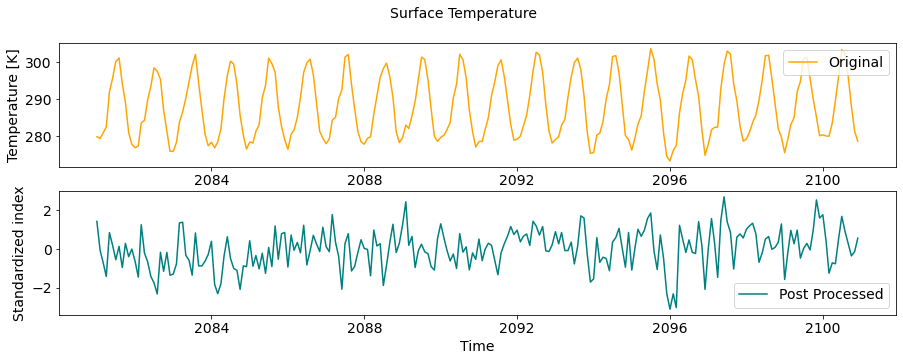

In [4]:
## Make a quick plot to look at TSF at an arbitrary point
fs = 14
fig,ax = plt.subplots(2,1,figsize=(15,5))
plt.suptitle('Surface Temperature', fontsize=fs)
ax[0].plot(time,TSF[:,15,15], c='orange', label='Original')
ax[0].set_ylabel('Temperature [K]', fontsize=fs)
ax[0].legend(fontsize=fs)
ax[0].tick_params(labelsize=fs)

ax[1].plot(time,TSFwgtanomSTD[:,15,15], c='teal', label='Post Processed')
ax[1].set_xlabel('Time', fontsize=fs)
ax[1].set_ylabel('Standardized index', fontsize=fs)
ax[1].legend(fontsize=fs)
ax[1].tick_params(labelsize=fs)

## Problem 1.2

In [5]:
## Prep for EOF analysis
# Reshape the data to be [time,spatial] instead of [time,lat,lon]
# We do this for both the standardized and original datasets  
# We want to project back to the original units later so that it makes more physical sense

a,b,c   = np.shape(TSFanom.values)  # have axis sizes for later (a, b, c)
Y = TSFanom.values.reshape(a,b*c)             # convert original data to [time,spatial]
Y_stand = TSFwgtanomSTD.values.reshape(a,b*c) # convert standardized data to [time,spatial]
print('dimensions:', a,b,c, '[time,lat,lon]')
print('original data new shape:', np.shape(Y))
print('STD data new shape:', np.shape(Y_stand))

dimensions: 240 31 65 [time,lat,lon]
original data new shape: (240, 2015)
STD data new shape: (240, 2015)


### eigenalanysis and SVD EOFs and PCs

In [6]:
# Get the Covariance matrix using standardized TSF
C = 1./np.size(Y_stand,axis = 0)*np.dot(np.transpose(Y_stand),Y_stand) ## Barnes Chapter 3 Equation 7
print(np.shape(Y_stand), '[MxN]')
print('C shape. Should be NxN:', np.shape(C))

#---------------------------------------------------------------
# eigenanalysis
# lambda is eigenvalues. E is eigenvectors (structure)
eigenvals, eigenvecs = LA.eig(C) ## Barnes Chapter 3 Equation 42
print('shape of lambda matrix:', np.shape(eigenvals))
print('shape of E matrix:', np.shape(eigenvecs))

# order by eigenvalues and eigenvectors by eigenvalues
ii  = np.flipud(np.argsort(eigenvals)) # flip up down
eigenvals = eigenvals[ii]
eigenvecs = eigenvecs[:,ii]

# convert eigenvalues to percent variance explained (pve)
pve_eigen = 100.*np.abs(eigenvals)/np.sum(np.abs(eigenvals))
print()
#---------------------------------------------------------------
# SVD
# columns of U are eigenvectors of XX^T
# columns of V are eigenvectors of X^TX
# S has the square root of eigenvalues.  Square these
U,S,V = LA.svd(Y_stand)  ## Barnes Chapter 3 Equation (65)
print('U shape. Should be MxM:', np.shape(U))
print('V shape. Should be NxN:', np.shape(V))
print('S shape. Should be NxN:', np.shape(S))
pve_SVD = 100.*np.abs(S**2)/np.sum(np.abs(S**2))


(240, 2015) [MxN]
C shape. Should be NxN: (2015, 2015)
shape of lambda matrix: (2015,)
shape of E matrix: (2015, 2015)

U shape. Should be MxM: (240, 240)
V shape. Should be NxN: (2015, 2015)
S shape. Should be NxN: (240,)


### Problem 1.3

In [ ]:
#---------------------------------------------------------------
# Calculate 95% confidence interval for the eigenvalues

def autocorrelation(data,lag):
    N = len(data) # sample length
    mean = np.mean(data) # get the mean
    sigma = np.std(data) # get the standard deviation
    data1 = data-mean    # get the turbulent quantities
    t1_m = data1[0:-1*lag] # normal timeseries
    t2_m = data1[lag:]     # lagged timeseries
    # correlate with numpy
    #AR1_np = np.correlate(t1_m,t2_m,mode='valid')/(N-lag)/(sigma**2) 
    # Barnes Chapter 2 Eq. 68 normalized by the variance (the dot product takes care of the sum in the equation)
    AR1 = np.dot(t1_m,t2_m)/(N-lag)/sigma**2 
    # calculate Nstar using 3 methods
    #Nstar = np.round((1-AR1_np)/(1+AR1_np)*N) # method 1
    Nstar2 = np.round(-0.5*np.log(AR1)*N)     # method 2
    Te = -1*lag/np.log(AR1)
    Nstar3 = np.round(N*lag/(2*Te))           # method 3
    return(AR1,Nstar2)

# cycle through each spatial coordinate and calculate it's Nstar at a lag of 1 for the full time period
# we have the lon and lat shape from before (b and c)
# send in the post processed datset (i.e. standardized, no seasonality, etc)
# The post-processed dataset already has a mean of 0 so we don't need to subtract it
# Use the lowest Nstar from all of the coordinates
Nstar_list = []
AR_list    = []
for i in range(b-1):
    for j in range(c-1):
        AR1,Nstar = autocorrelation(TSFwgtanomSTD[:,i,j],1)
        AR_list.append(AR1)
        Nstar_list.append(Nstar)
Nstar = round(np.mean(Nstar_list))
AR    = np.round(np.mean(AR_list),3)
print('average autocorrelation:', np.round(np.mean(AR_list),3))
print('average Nstar:', round(np.mean(Nstar_list)), '\n')

# 95% confidence error bars!
eb_eigen = pve_eigen*np.sqrt(2./Nstar)  ## North 1982, Barnes Chapter 3 Equation 80
eb_SVD = pve_SVD*np.sqrt(2./Nstar)  ## North 1982, Barnes Chapter 3 Equation 80

#---------------------------------------------------------------
# Take a look at percent variance explained by each method

fs = 18
fig = plt.figure(figsize=(10,10))
plt.plot(np.arange(1,len(pve_eigen)+1),pve_eigen,c='orange', lw=6,label='eigenanalysis',zorder=1)
plt.plot(np.arange(1,len(pve_SVD)+1),pve_SVD,c='teal', lw=2, label='SVD',zorder=1)
plt.scatter(np.arange(1,len(pve_eigen)+1),pve_eigen,c='black',s=30,zorder=2)
plt.scatter(np.arange(1,len(pve_SVD)+1),pve_SVD,c='black',s=30,zorder=2)
plt.errorbar(np.arange(1,np.size(pve_SVD)+1.),pve_SVD,yerr = eb_SVD/2, xerr = None, linewidth = 1, color = 'black');
plt.title('No Seasonal Cycle Removed', fontsize=fs)
plt.xlabel('Eigenvalue', fontsize=fs)
plt.ylabel('Variance Explained [%]', fontsize=fs)
plt.xlim([1,10]) # first 10
plt.ylim([1,30]) # max out at 30%
plt.legend(fontsize=fs)

#---------------------------------------------------------------
## How much variance is explained by the first 3 eigenvectors?
print(np.shape(pve_eigen))
print('eigenanalysis first three eigenvectors:', pve_eigen[0:3])
print('SVD first three eigenvectors:          ', pve_SVD[0:3])
print('total:', np.sum(pve_eigen[0:3]))


In [ ]:
#---------------------------------------------------------------
# How many statistically significant EOFs are there?
significant = []
not_significant = []
for i in range(len(pve_eigen)-1):
    lower = pve_eigen[i]-(eb_eigen[i]/2)
    if pve_eigen[i+1]+(eb_eigen[i+1]/2) < lower:
        significant.append(i)
    else:
        not_significant.append(i)
print('length:', len(significant))
print('index:', significant[-1])

total = 0
while total<95:
    total += pve_eigen[i]
print('total:', total)

length: 125
index: 1503


## Problem 1.4

In [91]:
def EOF_and_PCA_eigen(eof_num,eigenvecs,Y_stand):
    '''
    Compute EOF and PCA using eigenanalysis method
    Get the eigenvector associated with eof_num passed in
    Get the principle component (z1) associated with eof_num passed in
    '''
    # Find the eigenvector (e1) associated with "eof_num" from the eigenanalysis method
    e_eigen = eigenvecs[:,eof_num-1]
    # Calculate the principal component (z1) associated with "eof_num" from the eigenanalysis method
    z_eigen = np.dot(Y_stand,e_eigen)  ## Barnes Chapter 3 Eq. (50)
    # standardize it
    z_eigen = (z_eigen-np.mean(z_eigen))/np.std(z_eigen)  
    return(e_eigen,z_eigen)

def EOF_and_PCA_SVD(eof_num,U,V,S):
    '''
    Compute EOF and PCA using SVD method
    Get the eigenvector associated with eof_num passed in
    Get the principle component (z1) associated with eof_num passed in
    '''
    # Find the eigenvector (e1_svd) associated with "eof_num" from the SVD method
    e_svd = (V[eof_num-1,:]).reshape(b,c)
    # Calculate the principal component (z1_svd) associated with "eof_num" from the SVD method
    z_svd = U[:,eof_num-1]*(S[eof_num-1])
    # standardize it
    z_svd = (z_svd-np.mean(z_svd))/np.std(z_svd)  
    return(e_svd,z_svd)

e_eigen_list = []
e_svd_list   = []
z_eigen_list     = []
z_svd_list       = []
for i in range(1,11):
    e_eigen,z_eigen = EOF_and_PCA_eigen(i,eigenvecs,Y_stand)
    e_svd,z_svd     = EOF_and_PCA_SVD(i,U,V,S)
    e_eigen_list.append(e_eigen)
    e_svd_list.append(e_svd)
    z_eigen_list.append(z_eigen)
    z_svd_list.append(z_svd)
print('finished...')

finished...


/Users/daro8074/opt/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:2825: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/daro8074/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


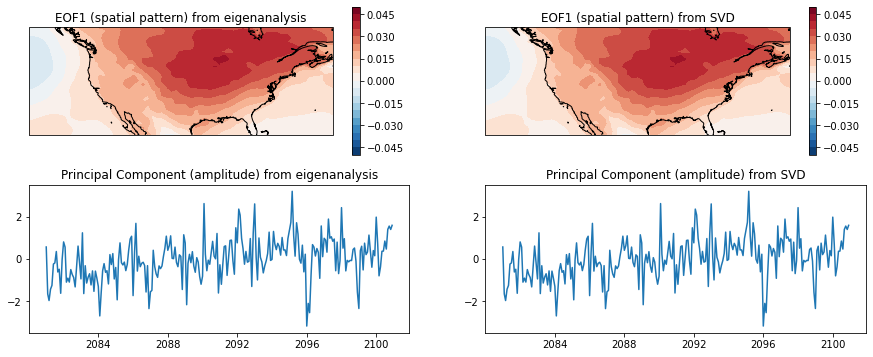

/Users/daro8074/opt/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:2825: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/daro8074/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


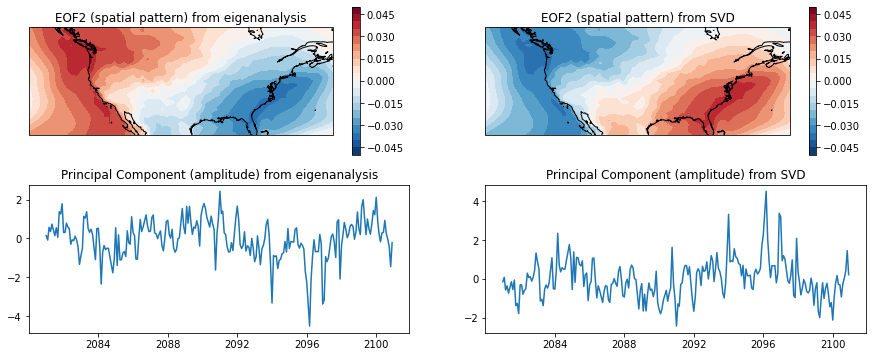

/Users/daro8074/opt/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:2825: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/daro8074/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


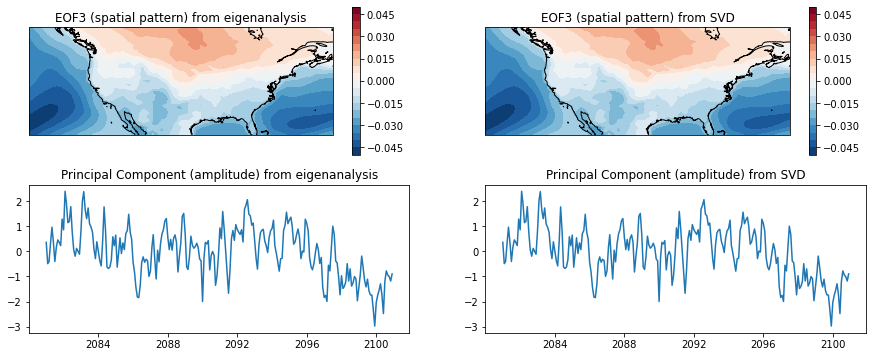

/Users/daro8074/opt/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:2825: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/daro8074/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


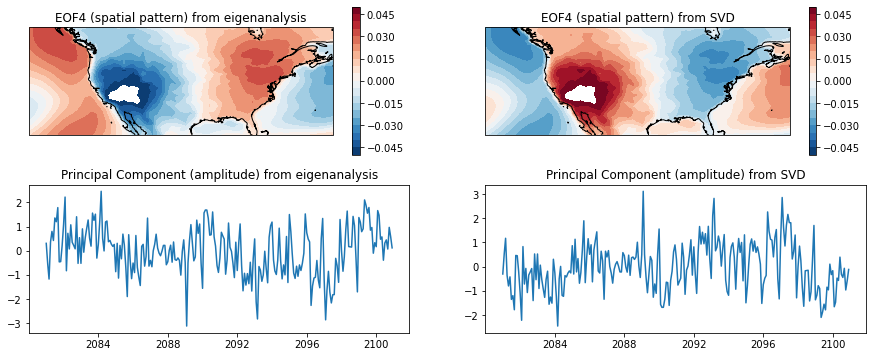

/Users/daro8074/opt/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:2825: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/daro8074/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


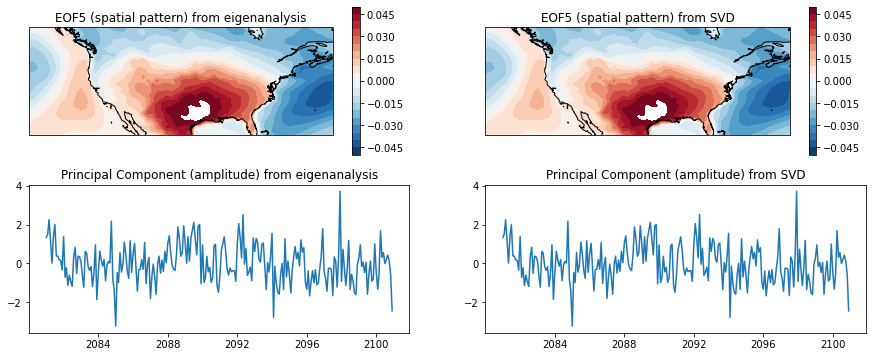

/Users/daro8074/opt/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:2825: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/daro8074/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


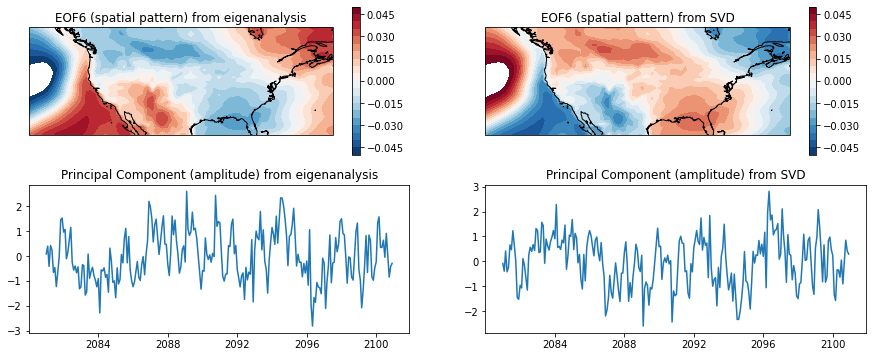

/Users/daro8074/opt/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:2825: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/daro8074/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


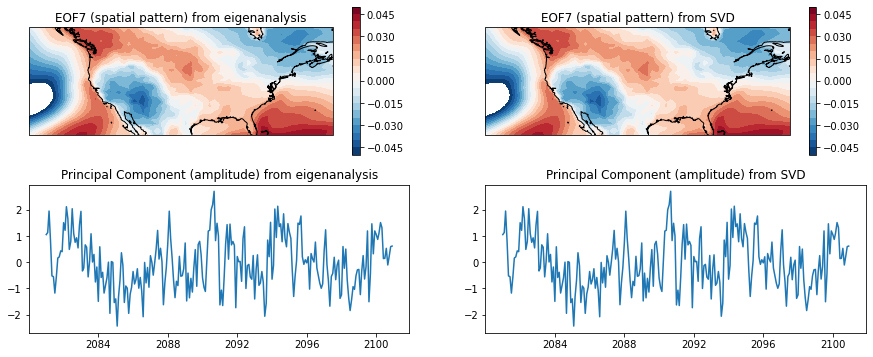

/Users/daro8074/opt/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:2825: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/daro8074/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


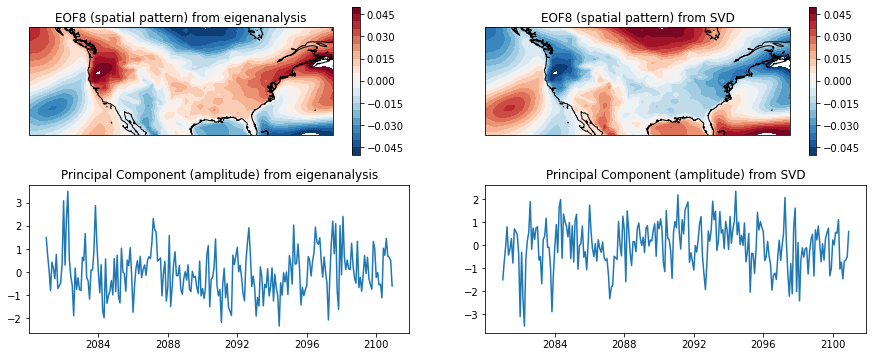

/Users/daro8074/opt/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:2825: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/daro8074/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


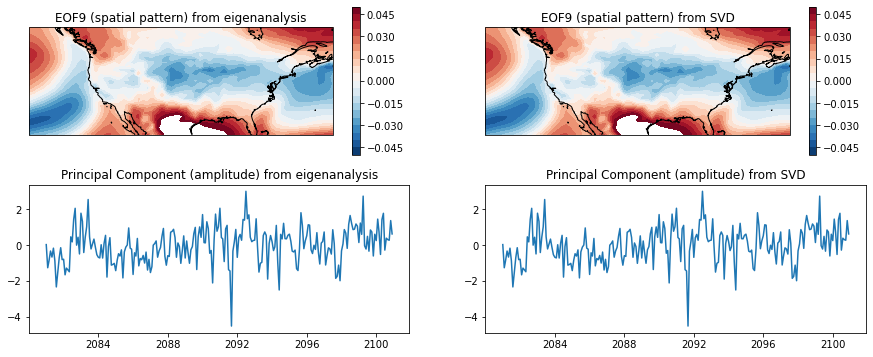

/Users/daro8074/opt/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:2825: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/daro8074/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


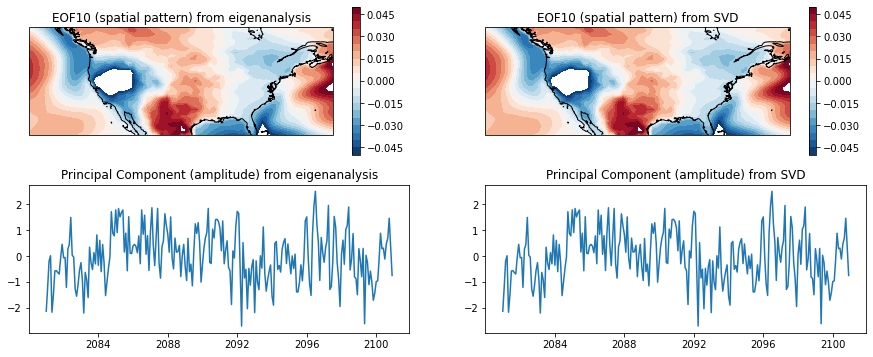

In [103]:
for i in range(0,10):    
    fig = plt.figure(figsize=(15,6))
    gs = GridSpec(2,2)
    levels=np.arange(-0.05,0.051,0.005)
    wesn = [nh_lon[0],nh_lon[-1],nh_lat[0],nh_lat[-1]]

    ax1 = plt.subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=180))
    ax1.set_extent(wesn,ccrs.PlateCarree())
    ax1.coastlines()
    CS = ax1.contourf(nh_lon,nh_lat,e_eigen_list[i].reshape(b,c),levels,cmap='RdBu_r',transform=ccrs.PlateCarree())
    plt.title('EOF'+str(i+1)+' (spatial pattern) from eigenanalysis')
    plt.colorbar(CS)
    plt.subplot(gs[1,0])
    plt.plot(time,z_eigen_list[i])
    plt.title('Principal Component (amplitude) from eigenanalysis')
    ##plt.xlim([0,900])  ## when the first EOF is the seasonal cycle

    ax1 = plt.subplot(gs[0,1],projection=ccrs.PlateCarree(central_longitude=180))
    ax1.set_extent(wesn,ccrs.PlateCarree())
    ax1.coastlines()
    CS = ax1.contourf(nh_lon,nh_lat,np.real(e_svd_list[i]),levels,cmap='RdBu_r',transform=ccrs.PlateCarree())
    plt.title('EOF'+str(i+1)+' (spatial pattern) from SVD')
    plt.ylabel('Amplitude of variation')
    plt.colorbar(CS)
    
    plt.subplot(gs[1,1])
    plt.plot(time,(z_svd_list[i]))
    plt.title('Principal Component (amplitude) from SVD')
    plt.show()
    plt.close()

## Problem 1.5

In [77]:
# STEP 5) Regress the data (unweighted data if applicable) onto standardize values of the PC 
# for eof_num above

# calculate d for plotting in physical units, not standardized/weighted units.
## d1 is in physical units (in this case degrees) and denotes the anomaly associated with 1 standard deviation
## of z1 (principal component, time variation in this case)
eof_num = 3
d1 = (1./np.size(Y,axis=0))*np.dot(np.transpose(z_svd_list[eof_num-1]),Y)   ## Barnes Chapter 3 Equation (79)
#print(np.shape(d1))
d1plot = d1.reshape(b,c)  ### this is the reshaped eigenvector to plot
#print(np.shape(d1plot))
print(min(d1))
print(max(d1))

# calculate d for plotting in standardized/weighted units
## d1s is in standardized units (in other words, no units) and denotes the anomaly associated with 1 standard deviation
## of z1 (principal component, time variation in this case)
d1s = (1./np.size(Y_stand,axis=0))*np.dot(np.transpose(z_svd_list[eof_num-1]),Y_stand)
#print(np.shape(d1))
d1splot = d1s.reshape(b,c)  ### this is the reshaped eigenvector to plot
print(min(d1s))
print(max(d1s))


-0.7599883114028647
1.0202172873239266
-0.7494829496523565
0.3523549263375008


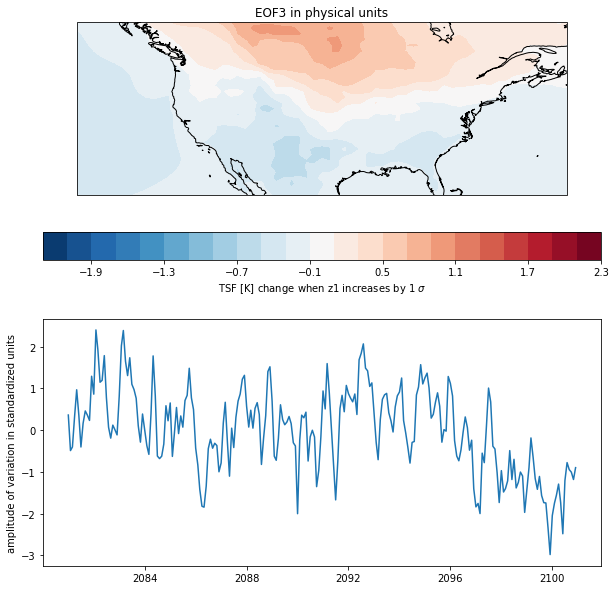

In [78]:
### Make a plot of the EOF in physical units and associated PC
fig = plt.figure(figsize=(10,10))
gs = GridSpec(2,1)
levels2 = np.arange(-0.7,0.71,0.1)
levels2 = levels2+1e-14 ### cartopy weirdness again
levels2 = np.arange(-2.3,2.5,0.2)
ax = plt.subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines()

CS = ax.contourf(nh_lon,nh_lat,d1plot,levels2,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
cb = plt.colorbar(CS,orientation='horizontal')
cb.set_label('TSF [K] change when z1 increases by 1 $\sigma$')
plt.title('EOF'+str(eof_num)+' in physical units')
plt.subplot(gs[1,0])
plt.plot(time,z_svd_list[eof_num-1])
plt.ylabel('amplitude of variation in standardized units');